
##  <center>Multivariant Linear Regression from scratch.</center>

------------------

The data we will be using is a ex1data2.txt file which contains a list of bedroom sizes, number of bedrooms and their corresponding price of the house.

The values on the <strong>first column</strong> contains the <strong>bedroom sizes</strong>, the values of the <strong>second column</strong> contains the <strong>number of bedrooms</strong> and values on the <strong>third column</strong> contains the corresponding <strong>price</strong> of the house in Naira.

<strong>Objective</strong>: To build a multivariate linear regression model and the optimization technique to generate a model that will predict reasonable estimate of a house price when it is supplied the customers desired room size and number of rooms.

## 1. Loading Data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
column_names = ["size","bedroom","price"]
data = pd.read_csv('ex1data2.txt', names = column_names)

- Display 5 random samples

In [3]:
data.sample(10)

,size,bedroom,price
42,2567,4,314000
18,2609,4,499998
11,2000,3,347000
43,1200,3,299000
14,1268,3,259900
35,1437,3,249900
16,1320,2,299900
38,4215,4,549000
10,1940,4,239999
40,1664,2,368500


- Data shape

In [4]:
print('data shape: {}, column size: {}, row size: {}' \
      .format(data.shape, data.shape[0], data.shape[1]))

data shape: (47, 3), column size: 47, row size: 3


----------------------------------------

# 2. Exploratory Data Analysis

In [5]:
# Data Summary
data.describe()

,size,bedroom,price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


In [6]:
# Correlation 
corr = data.corr()
corr.style.background_gradient(cmap='Spectral')

,size,bedroom,price
size,1,0.559967,0.854988
bedroom,0.559967,1,0.442261
price,0.854988,0.442261,1


## 2.1 Visualization

It is a good practice to visualize your data before building a model. The aim of data visualization is to give you an insight on the problem. We will be using matplotlib and seaborn libracy for visuals.

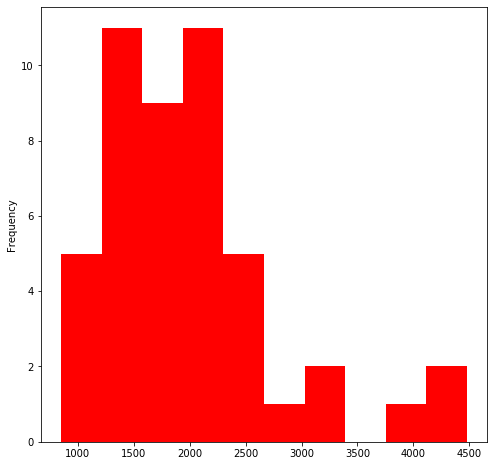

In [7]:
data['size'].plot(kind='hist',figsize=(8,8), color='red')

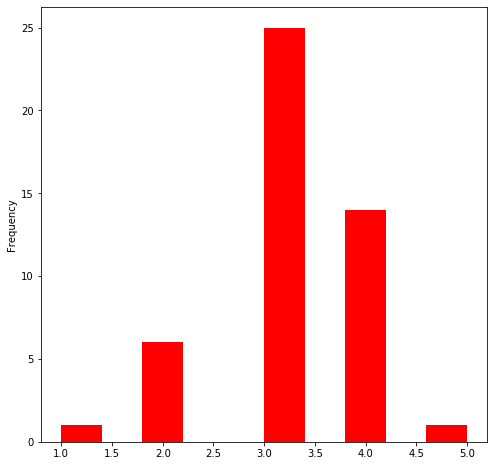

In [8]:
data['bedroom'].plot(kind='hist',figsize=(8,8), color='red')

Text(0.5, 1.0, 'ROOM SIZE VS PRICE')

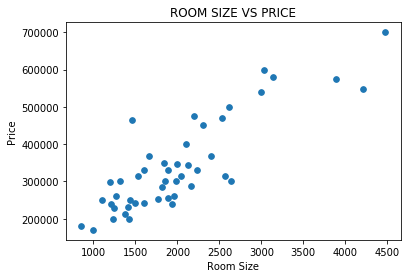

In [9]:
# Lets plot the data to see how they correlate.
plt.scatter(data.loc[:,'size'], data['price'], s=32, marker='o')
plt.xlabel("Room Size")
plt.ylabel("Price")
plt.title("ROOM SIZE VS PRICE")

Text(0.5, 1.0, 'NUMBER OF ROOMS VS PRICE')

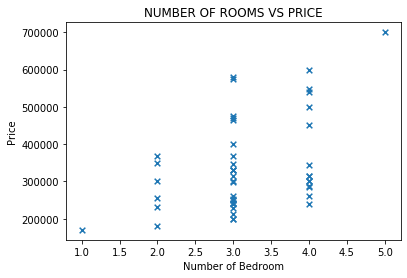

In [10]:
plt.scatter(data.loc[:,'bedroom'], data['price'], s=32, marker='x')
plt.xlabel("Number of Bedroom")
plt.ylabel("Price")
plt.title("NUMBER OF ROOMS VS PRICE")

--------------------------------------

# 3. Problem Formulation

We have 47 training examples and two independent variable `x` on the first and second column and one dependent variable `y` on the third column

**Recall:**
- Our untrained model is given by: ![title](img/model.gif)
    
- Which you can also be written as ![title](img/model2.gif)

where:
- `y` is the ground truth or output
- `x` is the input values
- `theta` is the <strong>weight or learnable parameters</strong>


Beacuse we have three coefficient of `theta` `( x1, x2)`, we want to create a `97 x 2` matrix that contains the input values on the first column and second column.

Notice that unlike in the last class, we did not create a third column here that contains `ones` which are coefficients for the **bias** `ie (theta0)`. This is because we would still have to normalize the input data. and it makes no sense normalizing `ones`, because we want them to remain as `ones`.

In [26]:
# input values - xs and 1s
nrows = data.shape[0]
ncols = data.shape[1]

x = data.loc[:, ['size','bedroom']].values #converts to Numpy array
x = x.reshape(nrows, 2)  # Alternatively x.reshape(-1,1)

Similarly, we want to create a row vector with a dimension of 47 x 1 for all the output values in our dataset

In [12]:
# output variable 
y = data.loc[:, 'price'].values # convert to Numpy array
y = y.reshape(nrows, 1)

In [13]:
y.shape

(47, 1)

-------------------------------------

# 4. Feature Normalization

![title](img/prepro1.jpeg)

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance. 
In this notebook, we will normalize our data using the formula below
![title](img/norm.gif)

In [29]:
def featureNorm(x_data):
    # save the feature data in another variable
    x_norm = x_data.copy()
    
    # Create a row vector of zeros, having the same number of rows as the input feature
    mean = np.mean(x_data, axis=0)
    x_mean = np.mean(x_data[:, :2], axis = 0)
    x_std = np.std(x_data[:, :2], axis = 0)
    
    print('Mean and std of room sizes: {}: {} respectively'.format(x_mean[0],x_std[0]))
    print('Mean and std of bedrooms : {}: {} respectively'.format(x_mean[1],x_std[1]))
    
    # Using the above formula
    x_norm = np.divide((x_data[:, :2] - x_mean), x_std)
    
    # Insert one vector that represents the coefficient of the bias 
    x_norm = np.insert(x_norm, 0, 1, axis=1)
    print('A ones vector has been successfully concatenated to the input feature matrix')
    
    return x_norm, x_mean, x_std

In [30]:
x_norm, x_mean, x_std = featureNorm(x)

Mean and std of room sizes: 2000.6808510638298: 786.2026187430467 respectively
Mean and std of bedrooms : 3.1702127659574466: 0.7528428090618781 respectively
A ones vector has been successfully concatenated to the input feature matrix


-----------------------------------

# 5. Training

Recall from the class, the process to training a linear regression model is as follow.

We want to find the appropriate value of `theta` that will give us a good estimate of a city's profit if lthe city's population is supplied.

To do this, 
- We want to start with a random value of `theta` to generate a hypothesis
![title](img/model3.gif)

- Then continually correct values of `theta` until the deviation of the hypothesis/prediction `h` from the ground-truth `y` is greatly reduced

**Note:** In the last class, we used something like this `theta = [[0],[0],[0]]` to initialize the values of theta. Going forward, we will use the numpy function to initialize the values of theta, because we could have large number of theta values. ie `theta = np.zeros(3,1)`

In [34]:
def train(x,y, print_every):
    #print_every = 40
    iteration = 1000
    
    # For this practice are initiallizing are theta with values of zero.
    theta = np.zeros((3,1))
    
    # Here, want to save our cost function or loss or square error, 
    # so that we can have an idea of how the deviation of the hypothesis from the ground thruth reduces
    cost_function = np.zeros(iteration)
    
    for i in range(0, iteration):
        # Step 1: we make a prediction using the random weights (theta) that we initialized
        # @ is a fancy way do performing dot products
        h = x @ theta
        
        # Step 2: We take a step to correct the weights (theta) to that the next predicion will be better
        theta = update_weight(h, theta, x)
        
        # Step 3: We measure the deviation or error
        cost_function[i] = cost(x, theta)
        
        if i % print_every == 0:
            #print("Running Gradient Descent. Iteration: {} cost function: {}".format(np.log(iteration,cost_function[i]))
            print("Iteration: {}, Cost function: {} ".format(i, np.log(cost_function[i])))
        
    return theta, cost_function

But how do we check the error like we defined above?

Remember the error formular (cost function)? 
![title](img/model44.gif)

where:
- `m` is the number of training example
- `x` is the input data
- `h` is the hypothesis
- `y` is the prediction

The equation tries to find the square error between the ground truth and the prediction.


In [35]:
def cost(x, theta):
    m = x[:,0].size
    h = x @ theta
    return (1/2*m) * np.sum(np.square(h - y))

Now that we are able to get a sense of the error, how do we update how weight (theta) such that is predicts better?

Like we discussed in class, gradient descent algorithim will be used for this purpose.

The general formular for gradient is given below:
![title](img/model6.gif)
which can be differentiated to give:
![title](img/model5.gif)
where
- alpha is the learning rate

ie: we continually update the weight(theta) by taking steps(alpha) for the derived gradient of the error until we have sufficiently minimized theta.

In [36]:
def update_weight(h, theta, x):
    m = x[:,0].size
    alpha = 0.01
    theta = theta - alpha * (1/m * (x.T @ (h - y)))
    return theta

Now, lets pass in our data and train.

In [37]:
theta, cost_values = train(x_norm, y, 50)

Iteration: 0, Cost function: 32.58708608705592 
Iteration: 50, Cost function: 31.62646524555142 
Iteration: 100, Cost function: 30.768400809214164 
Iteration: 150, Cost function: 30.08272384143107 
Iteration: 200, Cost function: 29.624009990129288 
Iteration: 250, Cost function: 29.371264793925242 
Iteration: 300, Cost function: 29.249620101863503 
Iteration: 350, Cost function: 29.193821914890535 
Iteration: 400, Cost function: 29.16773135344796 
Iteration: 450, Cost function: 29.154828494508877 
Iteration: 500, Cost function: 29.14800073351936 
Iteration: 550, Cost function: 29.144156595722503 
Iteration: 600, Cost function: 29.141885780791473 
Iteration: 650, Cost function: 29.140499092567108 
Iteration: 700, Cost function: 29.1396341211269 
Iteration: 750, Cost function: 29.13908754832646 
Iteration: 800, Cost function: 29.138739515618084 
Iteration: 850, Cost function: 29.138516916385527 
Iteration: 900, Cost function: 29.138374179274354 
Iteration: 950, Cost function: 29.13828251

In [38]:
# Now, lets see our trained weights
print('Our learned value of theta: ',theta.ravel())

Our learned value of theta:  [340397.96353532 108742.65627238  -5873.22993383]


Lets visualize how or error reduced during the iteration. This is the power of gradient descent. 

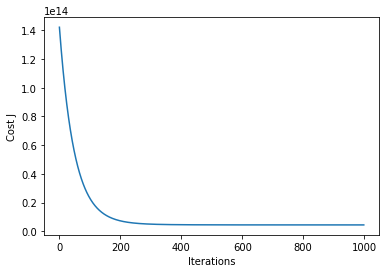

In [39]:
plt.plot(cost_values)
plt.ylabel('Cost J')
plt.xlabel('Iterations');

Notice that at the `400th iteration`, the model doesnt really change anymore. You should actually stop the iteration at that time and save cost of processing

## Predict

Lets write a predict function that takes in the input features and produces an estimate price for the type of house desired

In [ ]:
def predict(theta, x_mean, x_std):
    input_size = float(input("Input the size (square feet) of house you want: "))
    input_bedrooms = float(input("Input the number of bedrooms you desire: "))
    print("\n Calculating -- -- -- -- -- -- -- \n")
    
    # input vector
    input_vec = np.array([input_size, input_bedrooms])
    
    #print(input_vec_bias)
    
    # normalization of input vector
    input_norm = np.divide((input_vec -  x_mean), x_std)
    
     # input vector with bias
    input_vec_bias = np.insert(input_norm,0, 1)
    
    price = input_vec_bias @ theta
    print("For a house of size {} sqft, with {} bedrooms. The price of estimate is N{}".format(input_size,input_bedrooms,price[0]))

In [ ]:
predict(theta, x_mean, x_std)

-------------------

## Learning Rates

But what ius the effect of varying learning rates in the optimization of our weights?
Below, we will plot the effect of different learning on the optimization of theta.

Study the code for the next 5 mins...

In [40]:
# Choose some alpha value
alphas = [1,0,0.1,0.012]

def update_weight_r(h, theta, x, alpha):
    m = x[:,0].size
    theta = theta - alpha * (1/m * (x.T @ (h - y)))
    return theta

def cost_r(x):
    J = []
    theta = [[0],[0],[0]]
    iteration = 400
    for i in alphas:
        alpha = i
        m = x[:,0].size
        J_alpha = []
        for i in range(iteration):
            h = x @ theta
            theta = update_weight_r(h, theta, x, alpha)
            cost = (1/2*m) * np.sum(np.square(h - y))
            J_alpha.append(cost)
        # reset theta to zero
        theta = [[0],[0],[0]]
        J.append(J_alpha)
    return J


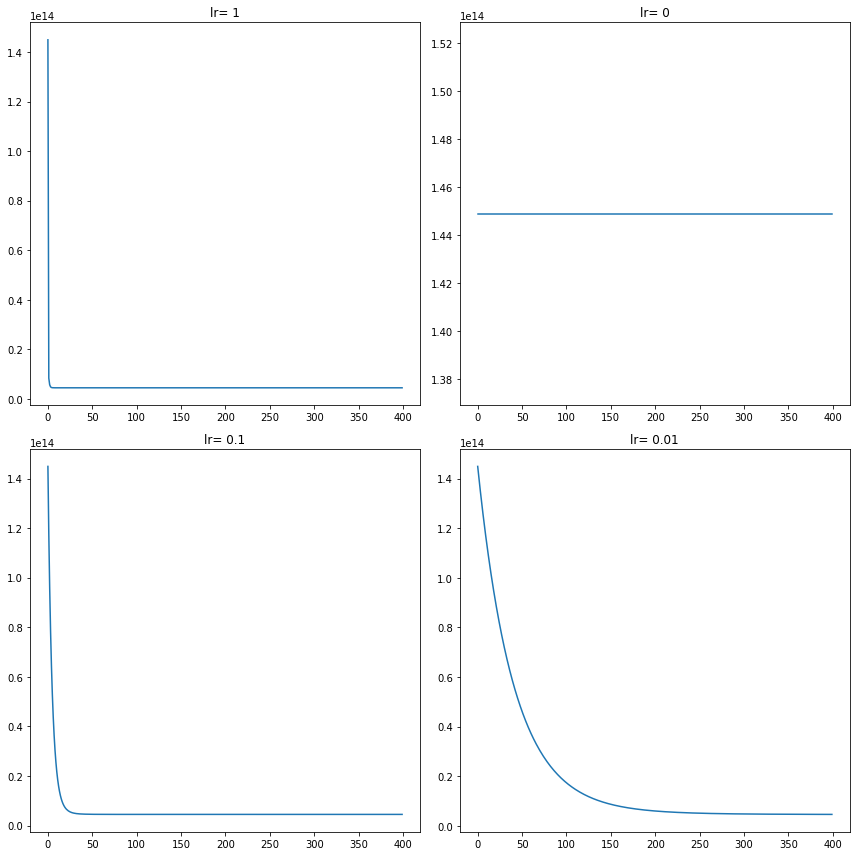

In [41]:
# Lets pass in the value of x into our function defined above 
cost_alpha = cost_r(x_norm)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(cost_alpha[0])
plt.title('lr= 1')

plt.subplot(2,2,2)
plt.plot(cost_alpha[1])
plt.title('lr= 0')

plt.subplot(2,2,3)
plt.plot(cost_alpha[2])
plt.title('lr= 0.1')

plt.subplot(2,2,4)
plt.plot(cost_alpha[3])
plt.title('lr= 0.01')

plt.tight_layout()

**Class Discussion/Assignment:** What did you notice in this plots

-----------------

# 7. Normal Equation (Analytical Method)

$$\theta = (X^TX)^{-1}X^T\vec{y}$$
Using this formula does not require any feature scaling, and you will get an exact solution in one calculation: there is no \loop until convergence" like in gradient descent.

Complete the code in normaleqn.py to use the formula above to calculate $\theta$. Remember that while you don't need to scale your features, we still need to add a column of 1's to the X matrix to have an intercept term

In [ ]:
# lets define the formula in a function
def normalEqn(X,y):
    return np.dot((np.linalg.inv(np.dot(X.T,X))),np.dot(X.T,y))

In [ ]:
# Lets pass in our input values the have not been normalized
x_non_norm = n_data = np.insert(data.iloc[:,:2].values,0,1, axis=1)

theta_analytical = normalEqn(x_non_norm, y)

# Display normal equation's result
print ('Theta computed from the normal equations:')
print (' %s \n' % theta_analytical)

In [ ]:
#Predict
def predict_analytical(theta):
    input_size = float(input("Input the size (square feet) of house you want: "))
    input_bedrooms = float(input("Input the number of bedrooms you desire: "))
    print("\nCalculating... ... ... ... ... ...\n")
    input_vec = np.array([[1, input_size, input_bedrooms]])
    
    
    price = input_vec @ theta
    print("For a house of size ", input_size, "sqft, with ", input_bedrooms, "bedrooms, \nThe price estimate is N", price[0][0])

In [ ]:
predict_analytical(theta_analytical)

--------------------------------

## Assignment:

1. Use `scikit-learn` to develop a linear regression model using the same dataset in this practice and compare result.
2. Explore the internet for an multivariant dataset and use this algorithim to train a linear regression model. Use `scikit-learn` too
3. Rewrite the train function such that we pass `'iteration',` and `'alpha'` as arguments.
4. What did you observe about the changing the `learning rate`?

Assignment is due for submission on `03/10/2019`.

Submission link will be posted on the `SLACK CHANNEL`

-------------------------

# Credit

This exercise is adopted from [Andrew Ng Machine Learning Course](https://www.coursera.org/learn/machine-learning)